## Reverse Regression on GTEx to calculate Q-scores

This notebook contains a minimal implementation of the reverse regression method. We apply the method on Adipose Subcutaneous tissue in GTEx v8 for ~2000 SNPs in chr21. 

#### Note: Running this notebook requires access to preprocessed GTEx data.

We look at the p-value distribution, compare the distribution of scaled Q-scores with the standard normal distribution. For one particular SNP, we shuffle the genotype multiple times to check if the mean and variance are correctly estimated by our method.

In [92]:
import numpy as np
import collections
import gzip

from scipy import stats
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
f_gx = "/scratch/sbanerj/trans-eqtl/input/gtex_v8/expression/gtexv8_as_raw_std_protein_coding.txt"
f_vcf = "/scratch/sbanerj/trans-eqtl/input/gtex_v8/genotype/all_samples/GTEX_v8_2019-07-29_WGS_838Indiv_Freeze_NoMissingGT_SNPfilter_MAF0.01_withDS_chr21.vcf.gz"
f_gtf = "/scratch/sbanerj/data/GENCODE/gencode.v26.annotation.gtf.gz"

In [3]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()


def read_gtex(rpkmfile):
    expr_list = list()
    donor_list = list()
    gene_list = list()
    with open(rpkmfile) as mfile:
        donor_list = mfile.readline().strip().split("\t")[1:]
        for line in mfile:
            linesplit = line.strip().split("\t")
            gene = linesplit[0].strip()
            gene_list.append(gene)
            expr = np.array([float(x) for x in linesplit[1:]])
            expr_list.append(expr)
    expr_list = np.transpose(np.array(expr_list))
    expr = np.transpose(np.array(expr_list)) ## see line 137 of iotools/readRPKM.py
    return expr, gene_list, donor_list

def read_vcf(filename, startsnp, endsnp):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith('chr'):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    dsindx = linesplit[8].split(':').index("DS")
                    ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                    gtindx = linesplit[8].split(':').index("GT")
                    for i, x in enumerate(ds):
                        if x == ".":
                            gt = linesplit[9+i].split(':')[gtindx]
                            if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                ds[i] = float(int(gt[0]) + int(gt[2]))

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                if linenum > endsnp: break
                linenum += 1

    return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

In [4]:
from sklearn.decomposition import PCA

def knn_correction(expr, dosage):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
    print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
    print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = 30
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        #noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn, neighbor_list

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtcent

def modify_gt_knn(gtsnp, neighbor_list):
    nsample = gtsnp.shape[0]
    kneighbor = 30
    gtmod = np.zeros_like(gtsnp)
    for i in range(nsample):
        neighbors = neighbor_list[i] #np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gtmod[i] = gtsnp[i] - np.mean(gtsnp[neighbors])
    gtmod = gtmod - np.mean(gtmod)
    return gtmod

In [5]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) \
                    + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) \
                    + v22*(q2**2 + 2*q22 - 3*q4) \
                    + 4*v31*(q31 - q4) \
                    + mu4*q4
    
    sigma2 = sigma2 - muQ**2

    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [6]:
def format_matrix(header, matrix, rownames,
                  top_format, left_format, cell_format, row_delim, col_delim):
    table = [[''] + header] + [[name] + row for name, row in zip(rownames, matrix)]
    table_format = [['{:^{}}'] + len(header) * [top_format]] \
                 + len(matrix) * [[left_format] + len(header) * [cell_format]]
    col_widths = [max(
                      len(format.format(cell, 0))
                      for format, cell in zip(col_format, col))
                  for col_format, col in zip(zip(*table_format), zip(*table))]
    return row_delim.join(
               col_delim.join(
                   format.format(cell, width)
                   for format, cell, width in zip(row_format, row, col_widths))
               for row_format, row in zip(table_format, table))

In [7]:
gtfull, snp_info, gt_donors = read_vcf(f_vcf, 0, 2000)
# newdosage = list()
# for i, snp in enumerate(snp_info):
#     bins = [0.66, 1.33]
#     intdosage = np.digitize(gtfull[i], bins)
#     newdosage.append(intdosage)
# gtint = np.array(newdosage)

In [8]:
gx_full, _, gx_donors = read_gtex(f_gx)

In [9]:
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
gx_norm = normalize_expr(gx_full[:, exprmask])
gtmask = gtfull[:, vcfmask]
gt_cent = normalize_and_center_dosage(gtmask, snp_info)
sigmax2 = np.var(gt_cent, axis = 1)

In [10]:
nsample = gx_norm.shape[1]

gx_corr, gt_corr, knn_neighbors = knn_correction(gx_norm.T, gtmask)
gx_knn = normalize_expr(gx_corr.T) #/ np.sqrt(nsample)
gt_knn = normalize_and_center_dosage(gt_corr, snp_info)

Original dimension: 581 x 13041
Reduced dimension: 581 x 581


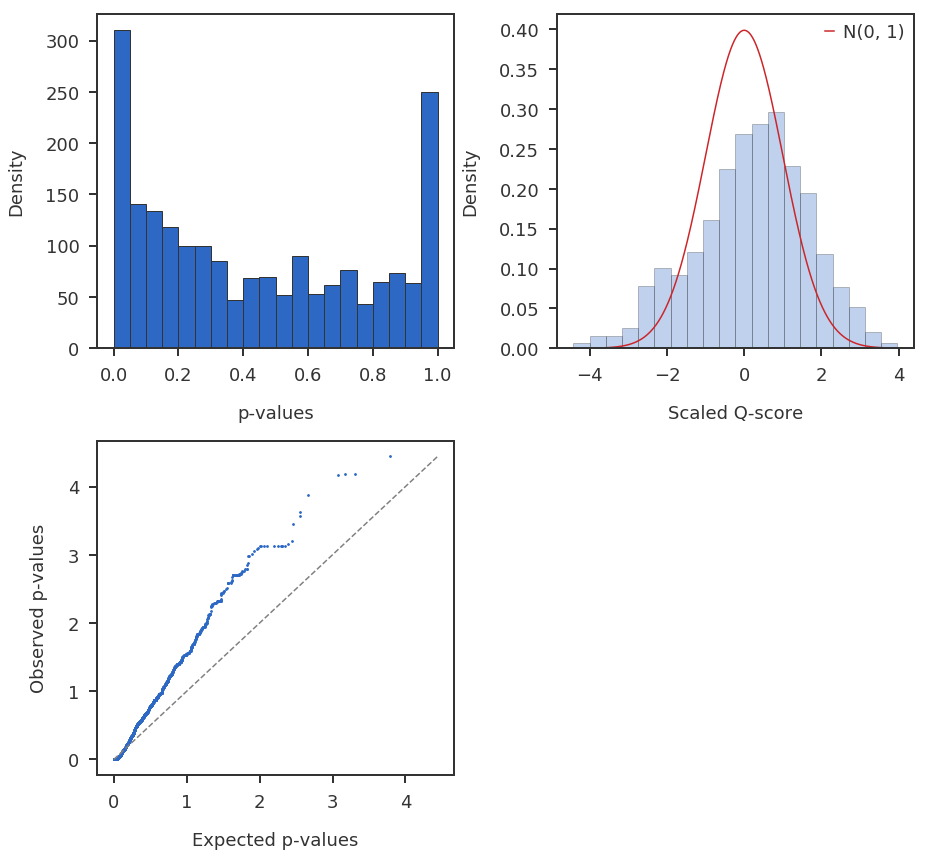

In [30]:
# Plot it for all SNPs

nsnps = gt_knn.shape[0]
pvals = list()
qstat = list()
qmean = list()
qvars = list()
qscale = list()

sigmabeta2 = 0.1 * 0.1
Yt = gx_knn.T
#Yt = gx_norm.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)


for i in range(nsnps):
#for i in range(10):
    gt = gt_knn[i, :].copy()
    #gt = gt_cent[i, :].copy()
    #gt = gt_cent_rand[i, :].copy()
    sigmax2 = np.var(gt)
    S2mod = S2 + sigmax2 / sigmabeta2

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, gt)) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(gt.reshape(1, -1), Qscore, W)
    scaledQ = (Qscore - muQ) / sigmaQ
    
    pvals.append(pval)
    qstat.append(Qscore)
    qmean.append(muQ)
    qvars.append(sigmaQ)
    qscale.append(scaledQ)

from scipy import stats

fig = plt.figure(figsize = (13, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

ax1.hist(pvals)

ax2.hist(qscale, alpha = 0.3, density = True)
xvals = np.linspace(min(qscale), max(qscale), 10000) 
rv = stats.norm(loc = 0, scale = 1)
ax2.plot(xvals, rv.pdf(xvals), label = "N(0, 1)")
ax2.legend()

log10pvals_rand_sorted = -np.log10(np.sort(np.random.uniform(0, 1, size = nsnps)))
log10pvals_sorted = -np.log10(np.sort(pvals))
pmax = np.max(log10pvals_sorted)
ax3.scatter(log10pvals_rand_sorted, log10pvals_sorted, s=3)
ax3.plot([0, pmax], [0, pmax], ls = 'dashed', color='gray')

ax1.set_xlabel('p-values')
ax1.set_ylabel('Density')
ax3.set_xlabel('Expected p-values')
ax3.set_ylabel('Observed p-values')
ax2.set_xlabel('Scaled Q-score')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

#### Are the mean and variance correctly estimated?

Shuffle the genotype and calculate Q-score 1000 times. Compare the mean and variance of these 1000 Q-scores with the analytical values obtained from our method.

====== KNN ======
Qscore: 580.8546522257483
muQ: 580.8496946050261
sigmaQ: 0.0069782981833344335
====== Null model ======
           |  Mean   |  Std 
Analytical | 580.850 | 0.007
 Empirical | 580.850 | 0.007


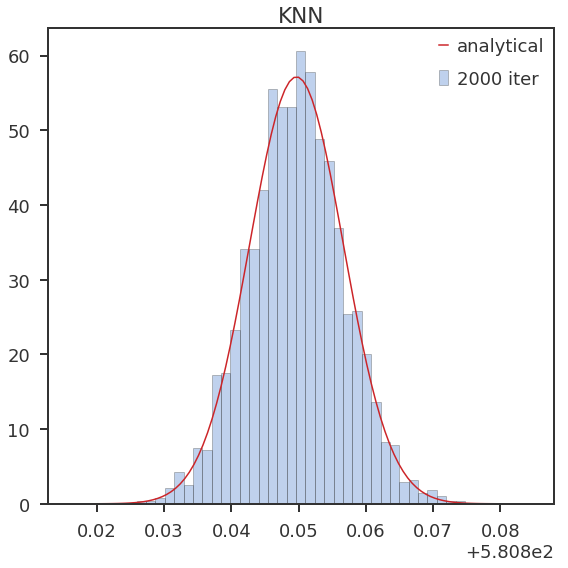

In [31]:
def shuffle_and_plot(GX, GT, ax, label):
    sigmabeta2 = 0.1 * 0.1
    niter = 2000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    
    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
    Qiter = np.zeros(niter)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod) / sigmax2

    print("====== {:s} ======".format(label))
    print("Qscore:", Qscore)
    print("muQ:", muQ)
    print("sigmaQ:", sigmaQ)
    
    xmax = np.max(Qiter) + 1.5 * sigmaQ
    xmin = np.min(Qiter) - 1.5 * sigmaQ
    #xmax = muQ + 4.0 * sigmaQ
    #xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    
    ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax.plot(x, rv.pdf(x), label = 'analytical')
    
    ax.set_title(label)
    
    print ("====== Null model ======")
    print (format_matrix(['Mean', 'Std'],
                         [[muQ, sigmaQ], [np.mean(Qiter), np.std(Qiter)]],
                         ['Analytical', 'Empirical'],
                         '{:^{}}', '{:>{}}', '{:>{}.3f}', '\n', ' | '))
    
    return W, Qiter
    
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

W, Qiter = shuffle_and_plot(gx_knn, gt_knn[0, :], ax1, "KNN")
ax1.legend()
plt.tight_layout()
plt.show()

While we are at it, let us also have a look at the gene expression distributions. Change the `geneix` variable to look at different genes.

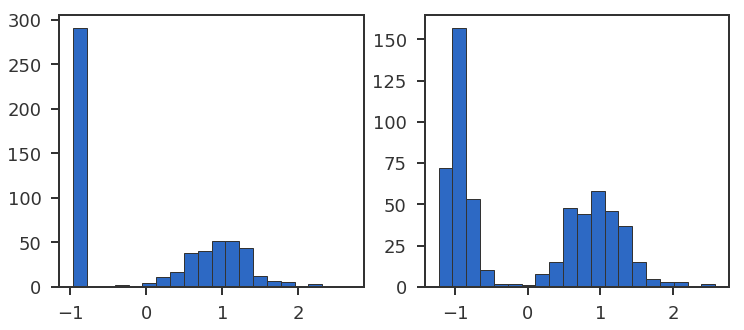

In [43]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
geneix = 200
ax1.hist(gx_full[geneix, :])
ax2.hist(gx_knn[geneix, :])
plt.show()